# MDETR - Modulated Detection for End-to-End Multi-Modal Understanding

Welcome to the demo notebook for MDETR. We'll show-case detection, segmentation and question answering



## Preliminaries

This section contains the initial boilerplate. Run it first.

In [ ]:
!pip install torch==1.11.0 torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 30.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 28.1 MB/s et

In [ ]:
!pip install tokenizers==0.11.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 17.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.40.0 requires tokenizers<0.20,>=0.19, but you have tokenizers 0.11.6 which is incompatible.


In [ ]:
!pip install timm==0.5.4 transformers==4.16.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 48.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0


In [ ]:
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import numpy as np
from skimage.measure import find_contours

from matplotlib import patches,  lines
from matplotlib.patches import Polygon

torch.set_grad_enabled(False);

In [ ]:
# standard PyTorch mean-std input image normalization
# transform = T.Compose([
#     T.Resize(800),
#     T.ToTensor(),
#     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Lambda(lambda x: x[:3]),
    T.Normalize([0.4640, 0.4604, 0.4540], [0.0945, 0.0923, 0.0964])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_results(filename, pil_img, scores, boxes, labels, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
          continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
          # Subtract the padding and flip (y, x) to (x, y)
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor="none", edgecolor=c)
          ax.add_patch(p)


    plt.imshow(np_image)
    plt.axis('off')
    plt.show()
    plt.savefig(filename)

def add_res(results, ax, color='green'):
    #for tt in results.values():
    if True:
        bboxes = results['boxes']
        labels = results['labels']
        scores = results['scores']
        #keep = scores >= 0.0
        #bboxes = bboxes[keep].tolist()
        #labels = labels[keep].tolist()
        #scores = scores[keep].tolist()
    #print(torchvision.ops.box_iou(tt['boxes'].cpu().detach(), torch.as_tensor([[xmin, ymin, xmax, ymax]])))

    colors = ['purple', 'yellow', 'red', 'green', 'orange', 'pink']

    for i, (b, ll, ss) in enumerate(zip(bboxes, labels, scores)):
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, color=colors[i], linewidth=3))
        cls_name = ll if isinstance(ll,str) else CLASSES[ll]
        text = f'{cls_name}: {ss:.2f}'
        print(text)
        ax.text(b[0], b[1], text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

## Detection

In this section, we show the performance of our pre-trained model on modulated detection.
Keep in mind that this model wasn't fine-tuned for any specific task.

We load the model from torch hub

In [ ]:
model, postprocessor = torch.hub.load('ashkamath/mdetr:main', 'mdetr_resnet101', pretrained=True, return_postprocessor=True)
model = model.cuda()
model.eval();

Downloading: "https://github.com/ashkamath/mdetr/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Downloading: "https://zenodo.org/record/4721981/files/pretrained_resnet101_checkpoint.pth" to /root/.cache/torch/hub/checkpoints/pretrained_resnet101_checkpoint.pth


  0%|          | 0.00/2.76G [00:00<?, ?B/s]

Next, we retrieve an image on which we wish to test the model. Here, we use an image from the validation set of COCO

In [ ]:
im1 = Image.open("/content/CLEVR_test_000000.png")

In [ ]:
# url = "http://images.cocodataset.org/val2017/000000281759.jpg"
# im = Image.open(requests.get(url, stream=True).raw)

In [ ]:
im1

In [ ]:
im2 = Image.open("/content/CLEVR_test_000001.png")
im2

In [ ]:
def plot_inference(im, caption, filename):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0).cuda()

  # propagate through the model
  memory_cache = model(img, [caption], encode_and_save=True)
  outputs = model(img, [caption], encode_and_save=False, memory_cache=memory_cache)

  # keep only predictions with 0.7+ confidence
  probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
  keep = (probas > 0.7).cpu()

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

  # Extract the text spans predicted by each box
  positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
  predicted_spans = defaultdict(str)
  for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = memory_cache["tokenized"].token_to_chars(0, pos)
        predicted_spans [item] += " " + caption[span.start:span.end]

  labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
  plot_results(filename, im, probas[keep], bboxes_scaled, labels)

Let's first try to single out the salient objects in the image

/root/.cache/torch/hub/ashkamath_mdetr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


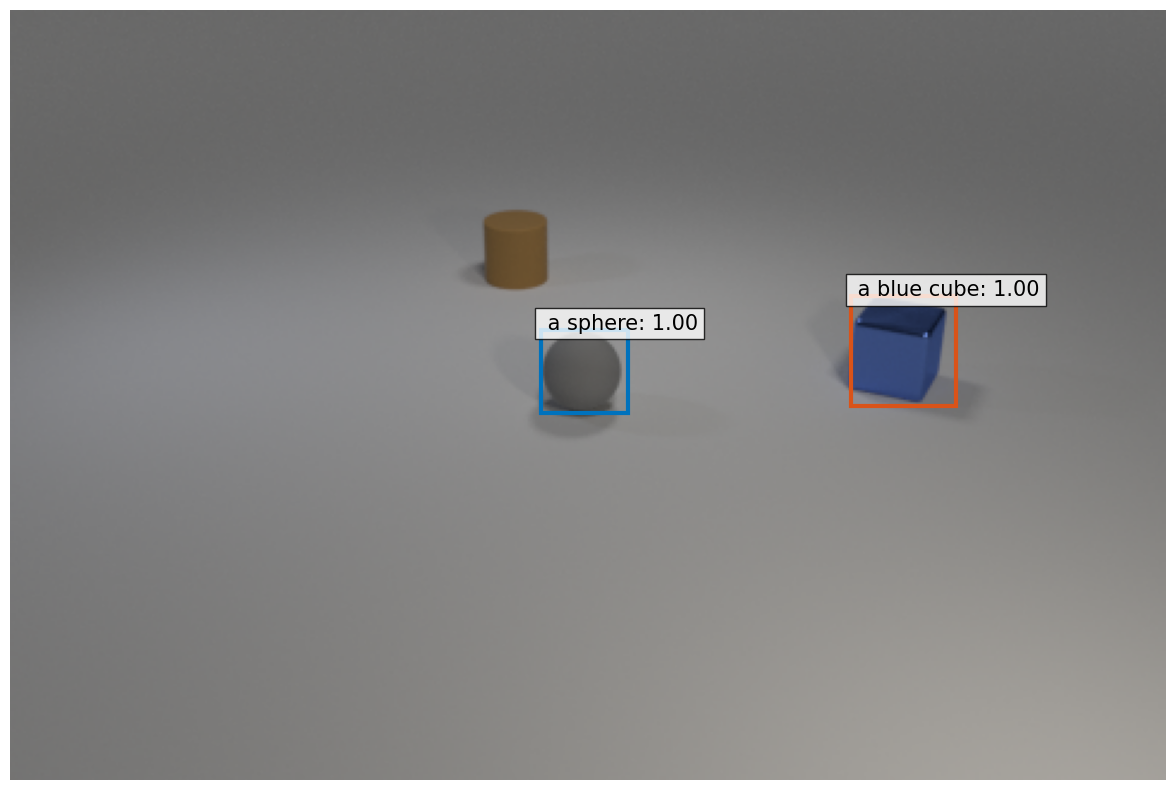

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_inference(im1, "a blue cube and a sphere", "detection_im1.png")

In [ ]:
plot_inference(im2, "a yellow cube and purple cylinder", "detection_im2.png")

<Figure size 640x480 with 0 Axes>

We can now ask to single out specific instances

/root/.cache/torch/hub/ashkamath_mdetr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


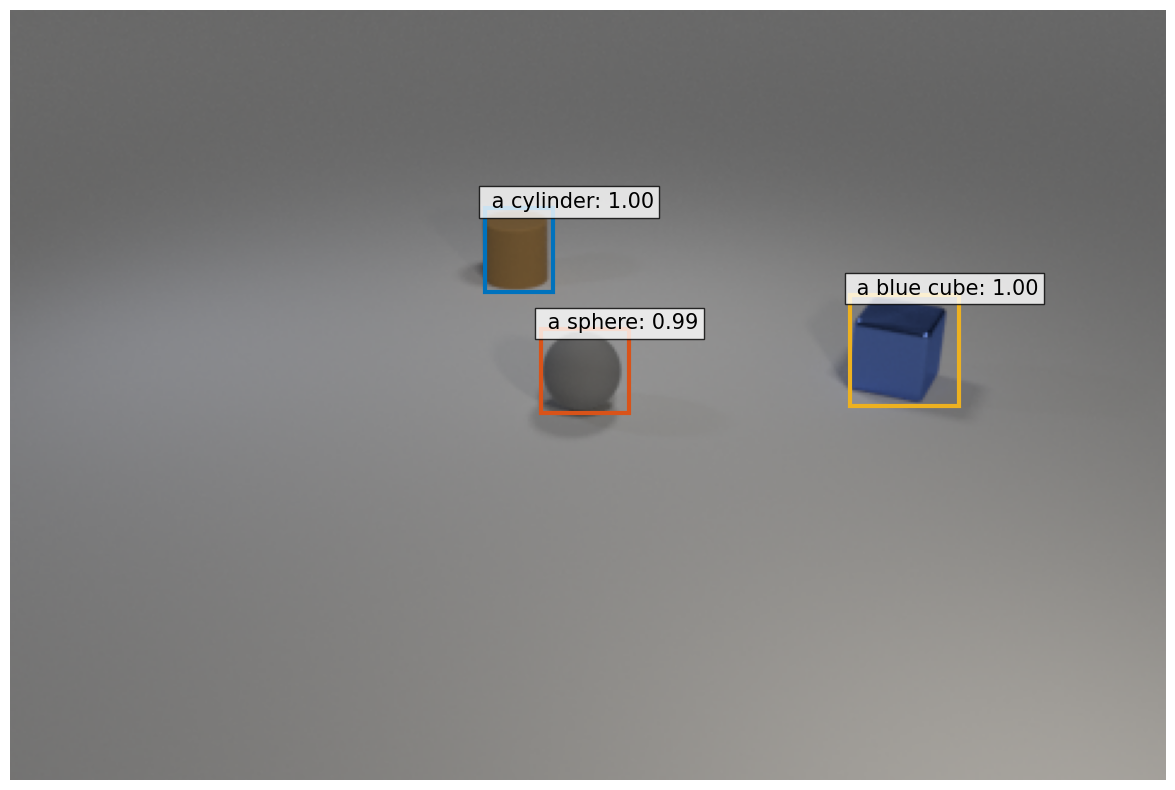

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_inference(im1, "a blue cube, a sphere and a cylinder", "detection2_im1.png")

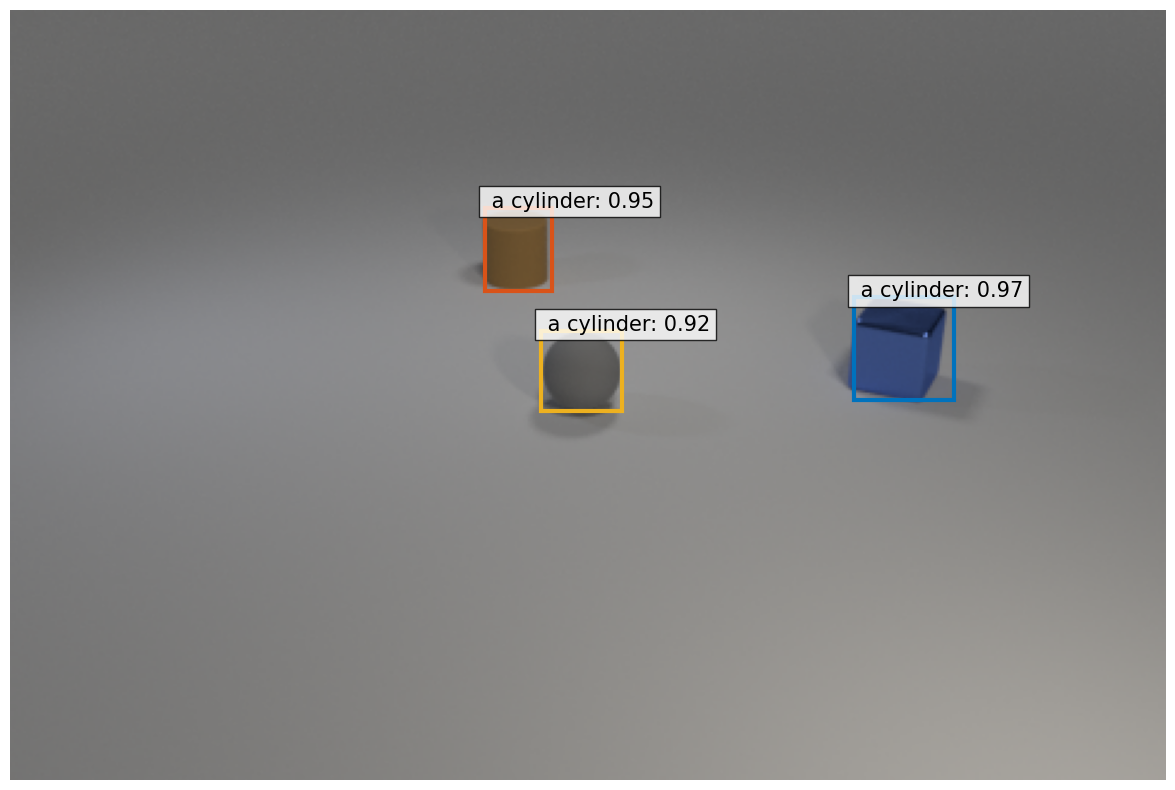

In [ ]:
plot_inference(im1, "a cylinder")

It can also find non-salient objects

Note that this model is trained with almost no negatives: during pre-training each text query is almost always associated to an object in the image. As a result, the model is biased to try to always output a detection, even if the object is not actually there (usually by picking the salient objects).

See the LVIS model for a model fine-tuned with negatives.

In [ ]:
plot_inference(im1, "a koala")

## Segmentation

To show-case segmentation, we use our model fine-tuned on phrase-cut. The captions in phrase-cut are usually very short, and contain ony one sentence. Keep this in mind while building your own prompts.

In [ ]:
model_pc = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB3_phrasecut', pretrained=True, return_postprocessor=False)
model_pc = model_pc.cuda()
model_pc.eval();

Using cache found in /root/.cache/torch/hub/ashkamath_mdetr_main
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Downloading: "https://zenodo

  0%|          | 0.00/1.16G [00:00<?, ?B/s]

In [ ]:
def plot_inference_segmentation(im, caption, filename):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0).cuda()

  # propagate through the model
  outputs = model_pc(img, [caption])

  # keep only predictions with 0.9+ confidence
  probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
  keep = (probas > 0.9).cpu()

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

  # Interpolate masks to the correct size
  w, h = im.size
  masks = F.interpolate(outputs["pred_masks"], size=(h, w), mode="bilinear", align_corners=False)
  masks = masks.cpu()[0, keep].sigmoid() > 0.5

  tokenized = model_pc.detr.transformer.tokenizer.batch_encode_plus([caption], padding="longest", return_tensors="pt").to(img.device)

  # Extract the text spans predicted by each box
  positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
  predicted_spans = defaultdict(str)
  for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = tokenized.token_to_chars(0, pos)
        predicted_spans [item] += " " + caption[span.start:span.end]

  labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
  plot_results(filename, im, probas[keep], bboxes_scaled, labels, masks)
  return outputs

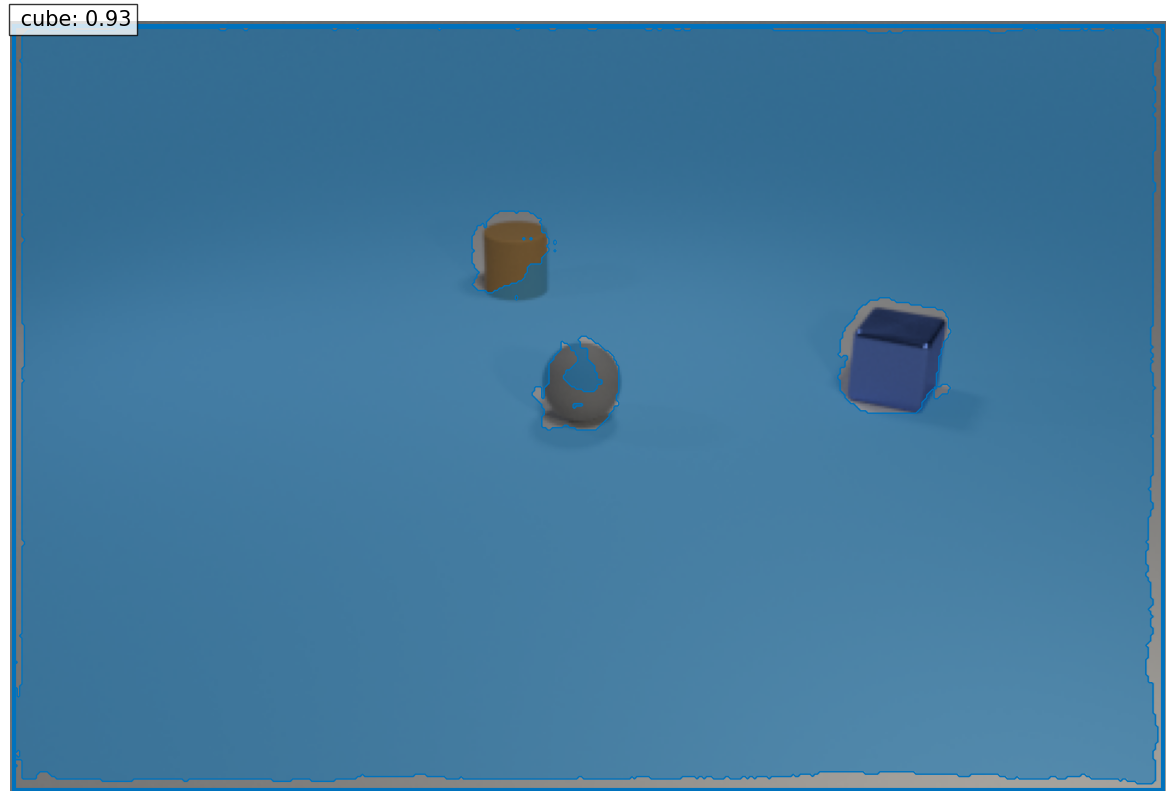

<Figure size 640x480 with 0 Axes>

In [ ]:
outputs = plot_inference_segmentation(im1, "cube", "segmentation_im1.png")

In [ ]:
outputs = plot_inference_segmentation(im2, "cylinder", "segmentation_im2.png")

<Figure size 640x480 with 0 Axes>

In [ ]:
im3 = Image.open("/content/CLEVR_train_000000.png")
im4 = Image.open("/content/CLEVR_train_000010.png")
im5 = Image.open("/content/CLEVR_train_000020.png")
im6 = Image.open("/content/CLEVR_train_000030.png")

In [ ]:
outputs = plot_inference_segmentation(im3, "sphere", "seg.png")

<Figure size 640x480 with 0 Axes>

In [ ]:
outputs = plot_inference_segmentation(im2, "cylinder", "seg.png")

<Figure size 640x480 with 0 Axes>

## Question answering

Finally, we demonstrate the inference on visual question answering. This model was trained on GQA, hence the questions must be similar (in particular, GQA doesn't contain counting questions)

In [ ]:
model_qa = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB5_gqa', pretrained=True, return_postprocessor=False)
model_qa = model_qa.cuda()
model_qa.eval();

Using cache found in /root/.cache/torch/hub/ashkamath_mdetr_main
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ns-6f26d0cf.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ns-6f26d0cf.pth
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Downloading: "https://zenodo

  0%|          | 0.00/2.54G [00:00<?, ?B/s]

We download the mapping from the answers to their id.

In [ ]:
import json

def load_json_objects(file_path):
    data = []
    with open(file_path, 'r') as file:
        content = file.read()
        # Attempt to decode JSON repeatedly
        while True:
            try:
                obj, idx = json.JSONDecoder().raw_decode(content)
                data.append(obj)
                content = content[idx:].lstrip()
            except json.JSONDecodeError:
                break
    return data

answer2id_by_type = load_json_objects("/content/answer2id.json")

id2answerbytype = {}
for ans_type in answer2id_by_type[0].keys():
    curr_reversed_dict = {v: k for k, v in answer2id_by_type[0][ans_type].items()}
    id2answerbytype[ans_type] = curr_reversed_dict

In [ ]:
print(answer2id_by_type[0])

{'answer_rel': {'yes': 0, '2': 1, 'no': 2, 'rubber': 3, 'large': 4, 'gray': 5, '0': 6, 'cube': 7, 'blue': 8, 'brown': 9, '1': 10, 'yellow': 11, 'purple': 12, 'cylinder': 13, 'small': 14, 'sphere': 15, 'green': 16, '4': 17, 'metal': 18, 'cyan': 19, '6': 20, '3': 21, 'red': 22, '5': 23, '8': 24, '7': 25, '9': 26, '10': 27}}


In [ ]:
import json
answer2id_by_type = json.load(requests.get("https://nyu.box.com/shared/static/j4rnpo8ixn6v0iznno2pim6ffj3jyaj8.json", stream=True).raw)
id2answerbytype = {}
for ans_type in answer2id_by_type.keys():
    curr_reversed_dict = {v: k for k, v in answer2id_by_type[ans_type].items()}
    id2answerbytype[ans_type] = curr_reversed_dict

In [ ]:
def plot_inference_qa(im, caption):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0).cuda()

  # propagate through the model
  memory_cache = model_qa(img, [caption], encode_and_save=True)
  outputs = model_qa(img, [caption], encode_and_save=False, memory_cache=memory_cache)

  # keep only predictions with 0.7+ confidence
  probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
  keep = (probas > 0.7).cpu()

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

  # Extract the text spans predicted by each box
  positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
  predicted_spans = defaultdict(str)
  for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = memory_cache["tokenized"].token_to_chars(0, pos)
        predicted_spans [item] += " " + caption[span.start:span.end]

  labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
  plot_results("img.png", im, probas[keep], bboxes_scaled, labels)

  # Classify the question type
  type_conf, type_pred = outputs["pred_answer_type"].softmax(-1).max(-1)
  ans_type = type_pred.item()
  types = ["obj", "attr", "rel", "global", "cat"]

  ans_conf, ans = outputs[f"pred_answer_{types[ans_type]}"][0].softmax(-1).max(-1)
  answer = id2answerbytype[f"answer_{types[ans_type]}"][ans.item()]
  print(f"Predicted answer: {answer}\t confidence={round(100 * type_conf.item() * ans_conf.item(), 2)}")

During question answering, we can still plot the boxes that are detected by the model, thus giving us a hint of what's happening under the hood.

/root/.cache/torch/hub/ashkamath_mdetr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


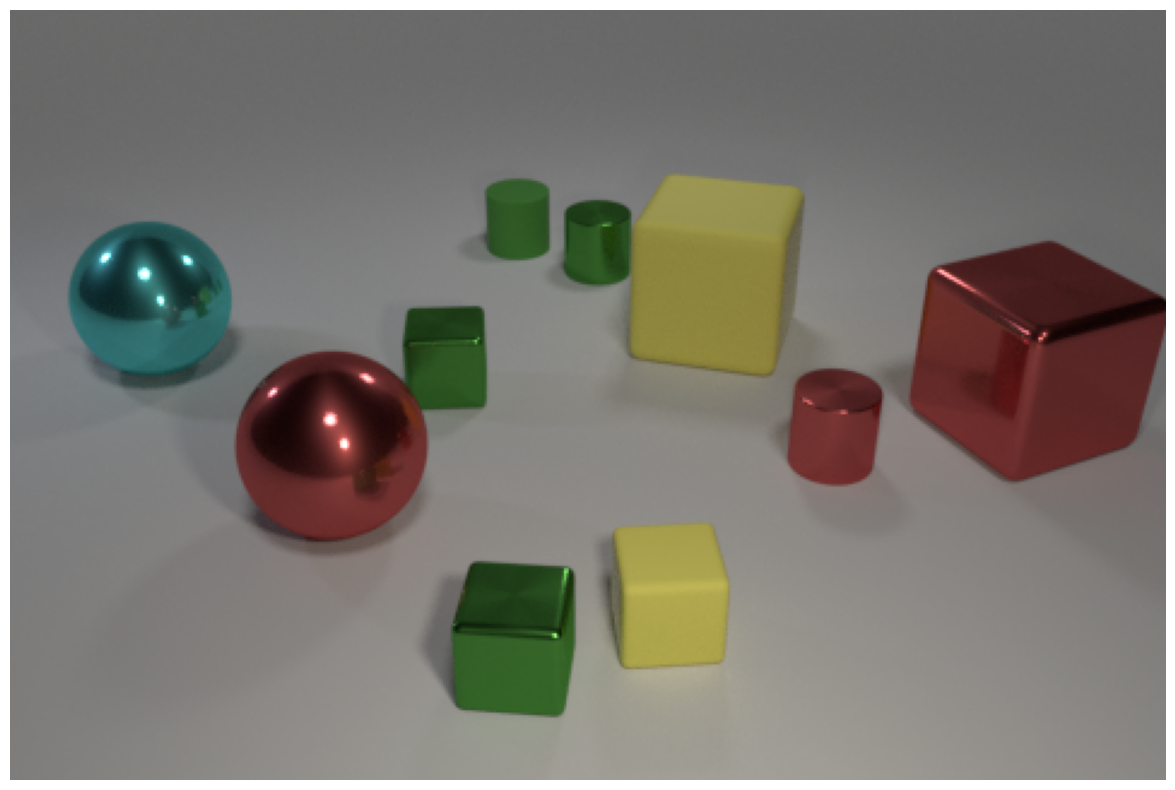

Predicted answer: yes	 confidence=46.07


<Figure size 640x480 with 0 Axes>

In [ ]:
plot_inference_qa(im4, "There is a small matte cylinder; is it the same color as the tiny shiny cube that is behind the large red metallic ball?")

/root/.cache/torch/hub/ashkamath_mdetr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


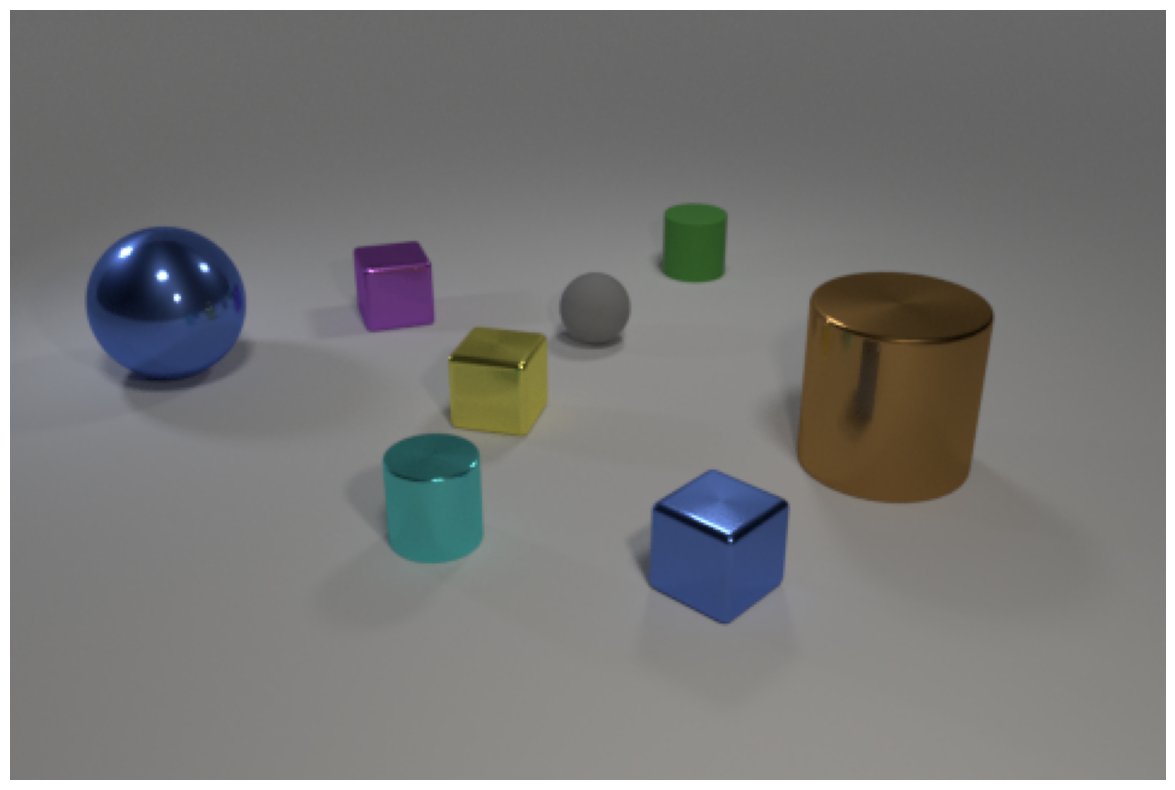

Predicted answer: left	 confidence=13.44


<Figure size 640x480 with 0 Axes>

In [ ]:
plot_inference_qa(im5, "What color is the metallic cylinder that is on the left side of the blue thing right of the tiny cylinder that is in front of the small gray object?")

/root/.cache/torch/hub/ashkamath_mdetr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


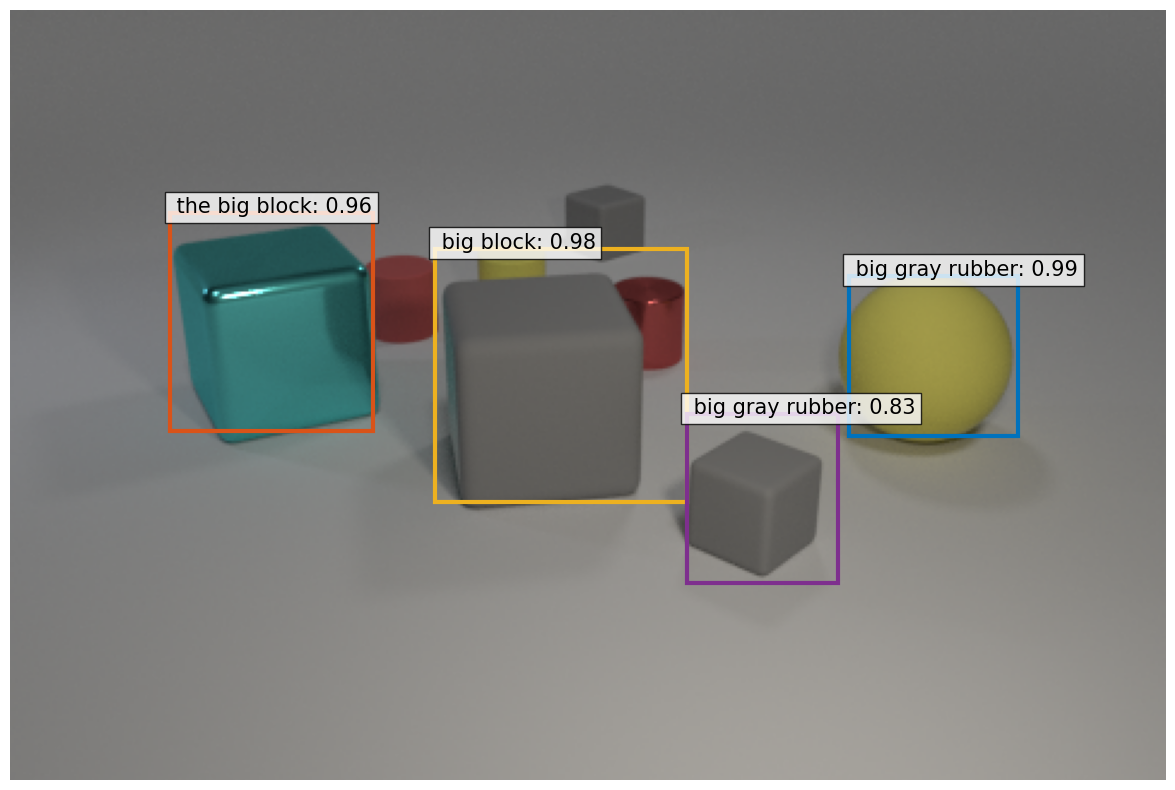

Predicted answer: plastic	 confidence=77.21


<Figure size 640x480 with 0 Axes>

In [ ]:
plot_inference_qa(im6, "What material is the big block that is to the left of the big gray rubber block in front of the cyan metallic object to the left of the yellow rubber cylinder?")

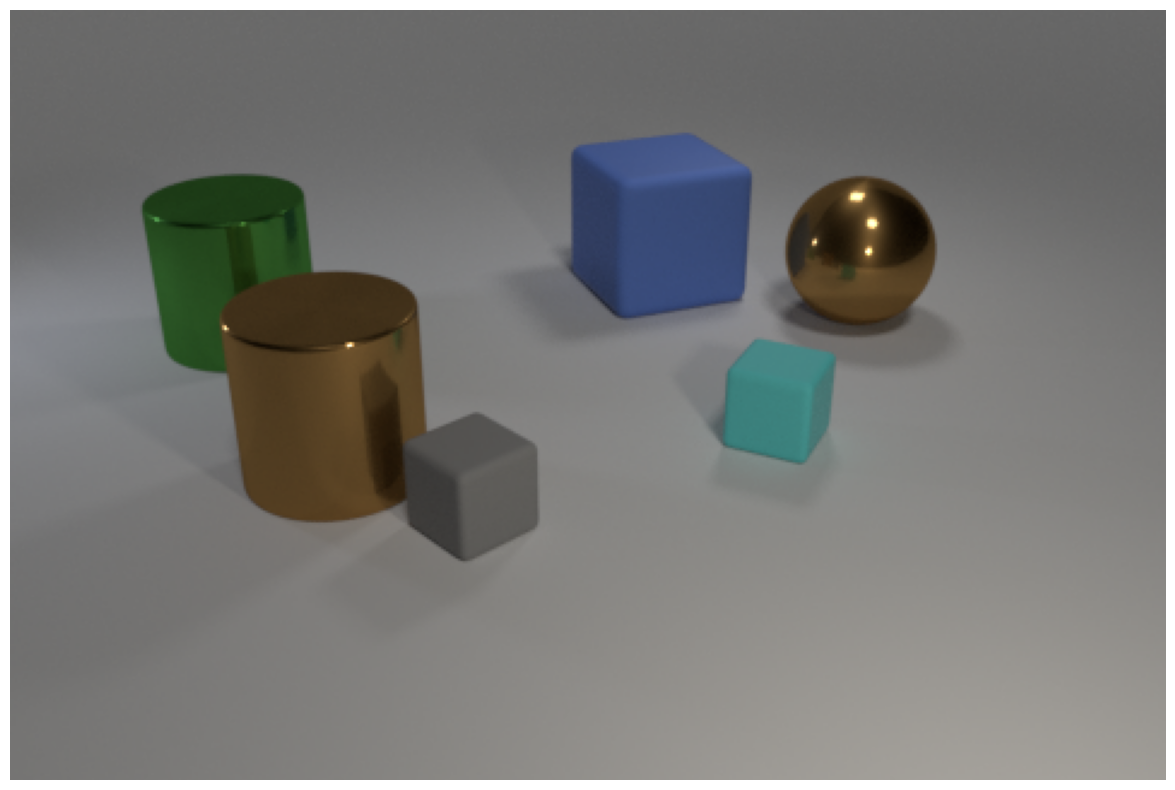

Predicted answer: no	 confidence=18.55


<Figure size 640x480 with 0 Axes>

In [ ]:
plot_inference_qa(im3, "Are there more big green things than large yellow shiny cubes?")